## IMPORTING LIBRARIES

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
import soccerdata as sd
import re

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "black"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

# setup a mplsoccer FontManager to download google fonts (Roboto-Regular / SigmarOne-Regular)
fm = FontManager()
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
                       'RubikMonoOne-Regular.ttf')

## SCRAPING DATA

In [295]:
def scrape_stats(mi):
    params = {'matchId': mi}
    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params)
    data = response.json()
    hometeam = data['general']['homeTeam']['name']
    awayteam = data['general']['awayTeam']['name']
    shotmap = data['content']['shotmap']['shots']
    top_stats = data['content']['stats']['Periods']['All']['stats'][0]['stats']
    pass_stats = data['content']['stats']['Periods']['All']['stats'][3]['stats']
    defensive_stats = data['content']['stats']['Periods']['All']['stats'][4]['stats']
    stats_df = pd.DataFrame(top_stats)
    passstats_df = pd.DataFrame(pass_stats)
    defensestats_df = pd.DataFrame(defensive_stats)
    shots_df = pd.DataFrame(shotmap)
    shots_df['matchId'] = mi
    stats_df['matchId'] = mi
    passstats_df['matchId'] = mi
    defensestats_df['matchId'] = mi
    return shots_df,stats_df,passstats_df,defensestats_df,hometeam,awayteam

In [296]:
df_shots,stats_df,passstats_df,defensestats_df,hometeam,awayteam = scrape_stats(4043864)

In [297]:
pitch = Pitch(pitch_type='custom',pitch_length = 105,pitch_width = 68, line_zorder=2
              ,pitch_color='black', line_color='white')

# subset the shots for each team
team1, team2 = df_shots.teamId.unique()
#teamcolor1,teamcolor2 = df_shots.teamColor.unique()
df_team1 = df_shots[(df_shots.teamId == team1) & (df_shots.eventType != 'Goal')].copy()
df_team2 = df_shots[(df_shots.teamId == team2) & (df_shots.eventType != 'Goal')].copy()

df_team1_goals = df_shots[(df_shots.teamId == team1) & (df_shots.eventType == 'Goal')].copy()
df_team2_goals = df_shots[(df_shots.teamId == team2) & (df_shots.eventType == 'Goal')].copy()

#team1_xg = round(df_team1['expectedGoals'].sum(),2) + round(df_team1_goals['expectedGoals'].sum(),2)
#team2_xg = round(round(df_team2['expectedGoals'].sum(),2) + round(df_team2_goals['expectedGoals'].sum(),2),2)
xG_list = stats_df[stats_df['title'] == 'Expected goals (xG)'].stats.tolist()
team1_xg,team2_xg = xG_list[0]
team1_xg = float(team1_xg)
team2_xg = float(team2_xg)

team1_goals = df_team1_goals[(df_team1_goals['eventType'] == 'Goal') & (df_team1_goals['isOwnGoal'] == False)].shape[0]
team2_goals = df_team2_goals[(df_team2_goals['eventType'] == 'Goal') & (df_team2_goals['isOwnGoal'] == False)].shape[0]

if df_team1_goals[(df_team1_goals['eventType'] == 'Goal') & (df_team1_goals['isOwnGoal'] == True)].shape[0] > 0:
    team2_goals += df_team1_goals[(df_team1_goals['eventType'] == 'Goal') & (df_team1_goals['isOwnGoal'] == True)].shape[0]
elif df_team2_goals[(df_team2_goals['eventType'] == 'Goal') & (df_team2_goals['isOwnGoal'] == True)].shape[0] > 0:
    team1_goals += df_team2_goals[(df_team2['eventType'] == 'Goal') & (df_team2_goals['isOwnGoal'] == True)].shape[0]

shots_list = stats_df[stats_df['title'] == 'Total shots'].stats.tolist()
team1_shots,team2_shots = shots_list[0]

shots_ot_list = stats_df[stats_df['title'] == 'Shots on target'].stats.tolist()
team1_shots_ot,team2_shots_ot = shots_ot_list[0]

possession = stats_df[stats_df['title'] == 'Ball possession'].stats.tolist()
team1_pos,team2_pos = possession[0]

acc_passes = stats_df[stats_df['title'] == 'Accurate passes'].stats.tolist()
team1_acc_passes,team2_acc_passes = acc_passes[0]

def string_value(str):
    # The input string
    input_string = str
    match = re.search(r'\((\d+)%\)', input_string) 
    if match:
        percentage_value = int(match.group(1))
    else:
        print("No match found")
    return percentage_value

team1_acc_passes = string_value(team1_acc_passes)
team2_acc_passes = string_value(team2_acc_passes)
saves = defensestats_df[defensestats_df['title'] == 'Keeper saves'].stats.tolist()
team1_saves,team2_saves = saves[0]

# Usually in football, the data is collected so the attacking direction is left to right.
# We can shift the coordinates via: new_x_coordinate = right_side - old_x_coordinate
# This is helpful for having one team shots on the left of the pitch and the other on the right
df_team1['x'] = pitch.dim.right - df_team1.x
df_team1_goals['x'] = pitch.dim.right - df_team1_goals.x

## ALL STATS MATCH REPORT

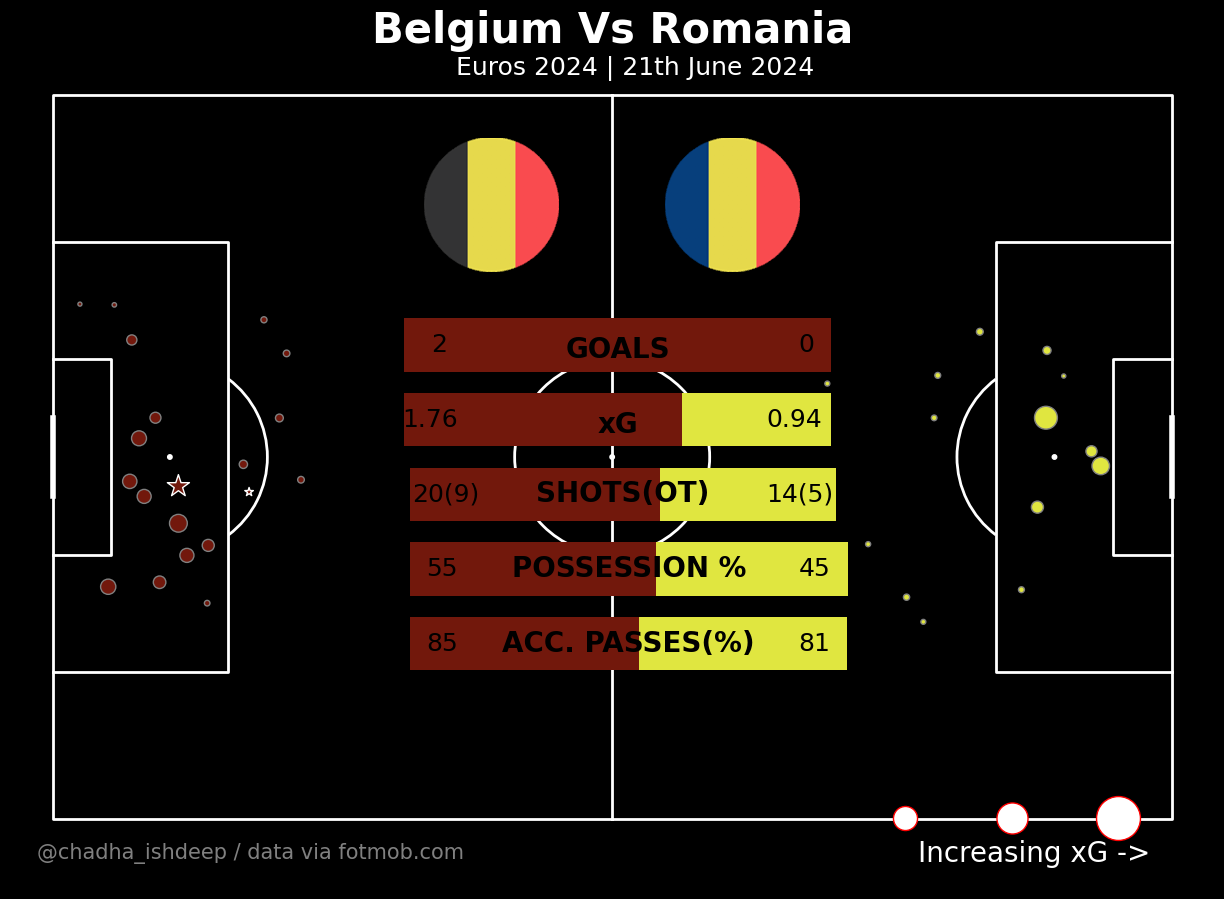

In [299]:
fig, axs = pitch.grid(grid_height=0.9, title_height=0.04, axis=False,
                     endnote_height=0.03, title_space=0, endnote_space=0)  # grid takes up 80% of the figure height


team1 = 'Belgium'
team2 = 'Romania'
#C:\Users\acer\Documents\GitHub\IndianCitizen\Images\TeamLogos
img_team1 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/Images/TeamLogos/{team1}.png')
img_team2 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/Images/TeamLogos/{team2}.png')
logo = mpimg.imread('C:/Users/acer/Documents/GitHub/IndianCitizen/Images/IndianCitizen.png')

ax_image = add_image(
    img_team1, fig, left=0.33, bottom=0.7, width=0.15, height=0.15,aspect='equal'
)

ax_image = add_image(
    img_team2, fig, left=0.52, bottom=0.7, width=0.15, height=0.15,aspect='equal'
)

team1_facecolor = '#72180C'
team2_facecolor = '#E0E640'


pitch.scatter(80,0.1,s=300,ec='red',color='white',ax=axs['pitch'],zorder=2)
pitch.scatter(90,0.1,s=500,ec='red',color='white',ax=axs['pitch'],zorder=2)
pitch.scatter(100,0.1,s=1000,ec='red',color='white',ax=axs['pitch'],zorder=2)

sc_team1 = pitch.scatter(df_team1.x, df_team1.y, s=df_team1.expectedGoals * 800,
                         ec='grey', color=team1_facecolor, ax=axs['pitch'],zorder=2)
sc_team1_goals = pitch.scatter(df_team1_goals.x, df_team1_goals.y, s=df_team1_goals.expectedGoals * 1000,
                         ec='white', color=team1_facecolor,marker='*', ax=axs['pitch'],zorder=2)
sc_team2 = pitch.scatter(df_team2.x, df_team2.y, s=df_team2.expectedGoals * 800,
                         ec='grey', color=team2_facecolor, ax=axs['pitch'],zorder=2)
sc_team2_goals = pitch.scatter(df_team2_goals.x, df_team2_goals.y, s=df_team2_goals.expectedGoals * 1000,
                         ec='white', color=team2_facecolor,marker='*', ax=axs['pitch'],zorder=2)

fig.set_facecolor('black')


# Set title
axs['pitch'].set_title(f'{team1} Vs {team2}',fontdict={'fontsize': 30, 'weight': 'bold', 'color': 'white'}, loc='center')
# Add subtitle
subtitle_text = "Euros 2024 | 21th June 2024"
axs['pitch'].text(0.37, 0.98, subtitle_text, ha='left', va='center', transform=axs['pitch'].transAxes, color='white', fontsize=18)



goals_team1 = team1_goals
goals_team2 = team2_goals

# Calculate the width of the rectangle for each team
total_goals = goals_team1 + goals_team2

# Define the minimum width for the rectangles
min_rect_width = 9

# Coordinates for the rectangle
rect_x = 33 # X-coordinate of the left side of the rectangle
rect_y = 42  # Y-coordinate of the top side of the rectangle
rect_width = 40  # Width of the rectangle
rect_height = 5  # Height of the rectangle

# Calculate the width of the rectangle for each team
# Calculate the width of the rectangle for each team
if goals_team1 == 0 and goals_team2 > 0:
    # If the home team scored 0 goals and the away team scored greater than 0
    width_team1 = 0
    width_team2 = 1
elif goals_team1 > 0 and goals_team2 == 0:
    # If the away team scored 0 goals and the home team scored greater than 0
    width_team1 = 1
    width_team2 = 0
elif total_goals > 0:
    # If both teams scored some goals
    width_team1 = max(goals_team1 / total_goals, min_rect_width / rect_width)
    width_team2 = max(goals_team2 / total_goals, min_rect_width / rect_width)
else:
    # Both teams scored 0 goals, set equal width for both
    width_team1 = 0.5
    width_team2 = 0.5


# Create a rectangle patch for team1
rect_team1 = Rectangle((rect_x, rect_y), width_team1 * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
rect_team2 = Rectangle((rect_x + width_team1 * rect_width, rect_y), width_team2 * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(rect_team1)
axs['pitch'].add_patch(rect_team2)

# Calculate the position for 'GOALS' text
goals_text_x = rect_x + width_team1 * rect_width + (width_team2 * rect_width - width_team1 * rect_width) / 2
goals_text_y = rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(37, rect_y + rect_height / 2, str(goals_team1), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(53, 44, 'GOALS', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'),zorder=2)
axs['pitch'].text(70, rect_y + rect_height / 2, str(goals_team2), color='black', ha='left', va='center',fontsize=18)

#### Adding xG

# Calculate the width of the rectangle for each team
total_xG = team1_xg + team2_xg
width_team1_xG = team1_xg / total_xG
width_team2_xG = team2_xg / total_xG

if width_team2_xG < 0.05:
    width_team1_xG = 1
    width_team2_xG = 0.05
elif width_team1_xG < 0.05:
    width_team2_xG = 1
    width_team1_xG = 0.05
    

# Coordinates for the rectangle
xG_rect_x = 33 # X-coordinate of the left side of the rectangle
xG_rect_y = 35 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
xG_rect_team1 = Rectangle((xG_rect_x, xG_rect_y), width_team1_xG * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
xG_rect_team2 = Rectangle((xG_rect_x + width_team1_xG * rect_width, xG_rect_y), width_team2_xG * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(xG_rect_team1)
axs['pitch'].add_patch(xG_rect_team2)

# Add labels for teams' goals
axs['pitch'].text(38, xG_rect_y + rect_height / 2, str(team1_xg), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(53, 37, 'xG', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(67, xG_rect_y + rect_height / 2, str(team2_xg), color='black', ha='left', va='center',fontsize=18)


#### Adding Shots
shots_team1 = team1_shots
shots_team2 = team2_shots

shots_team1_ot = team1_shots_ot
shots_team2_ot = team2_shots_ot

# Calculate the width of the rectangle for each team
total_shots = shots_team1 + shots_team2
width_team1_shots = shots_team1 / total_shots
width_team2_shots = shots_team2 / total_shots

if width_team2_shots < 0.05:
    width_team1_shots = 1
    width_team2_shots = 0.05
elif width_team1_shots < 0.05:
    width_team2_shots = 1
    width_team1_shots = 0.05

# Coordinates for the rectangle
shots_rect_x = 33.5 # X-coordinate of the left side of the rectangle
shots_rect_y = 28 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
shots_rect_team1 = Rectangle((shots_rect_x, shots_rect_y), width_team1_shots * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
shots_rect_team2 = Rectangle((shots_rect_x + width_team1_shots * rect_width, shots_rect_y), width_team2_shots * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(shots_rect_team1)
axs['pitch'].add_patch(shots_rect_team2)

# Calculate the position for 'GOALS' text
shots_text_x = shots_rect_x + width_team1_shots * rect_width + (width_team2_shots * rect_width - width_team1_shots * rect_width) / 2
shots_text_y = shots_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(40, shots_rect_y + rect_height / 2, str(shots_team1) + '(' + str(shots_team1_ot) + ')', color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(shots_text_x, shots_text_y, 'SHOTS(OT)', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(67, shots_rect_y + rect_height / 2, str(shots_team2) + '(' + str(shots_team2_ot) + ')', color='black', ha='left', va='center',fontsize=18)


#### Adding possesion
# Calculate the width of the rectangle for each team
total_possesion = team1_pos + team2_pos
width_team1_possesion = (team1_pos / total_possesion)*1.05
width_team2_possesion = team2_pos / total_possesion

# Coordinates for the rectangle
possesion_rect_x = 33.5 # X-coordinate of the left side of the rectangle
possesion_rect_y = 21 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
possesion_rect_team1 = Rectangle((possesion_rect_x, possesion_rect_y), width_team1_possesion * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
possesion_rect_team2 = Rectangle((possesion_rect_x + width_team1_possesion * rect_width, possesion_rect_y), width_team2_possesion * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(possesion_rect_team1)
axs['pitch'].add_patch(possesion_rect_team2)

# Calculate the position for 'GOALS' text
possesion_text_x = possesion_rect_x + width_team1_possesion * rect_width + (width_team2_possesion * rect_width - width_team1_possesion * rect_width) / 2
possesion_text_y = possesion_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(38, possesion_rect_y + rect_height / 2, str(team1_pos), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(possesion_text_x, possesion_text_y, 'POSSESSION %', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(70, possesion_rect_y + rect_height / 2, str(team2_pos), color='black', ha='left', va='center',fontsize=18)


#### Adding Accurate Passes
# Calculate the width of the rectangle for each team
total_acc_passes = team1_acc_passes + team2_acc_passes
width_team1_acc_passes = (team1_acc_passes / total_acc_passes)*1.05
width_team2_acc_passes = team2_acc_passes / total_acc_passes

# Coordinates for the rectangle
acc_passes_rect_x = 33.5 # X-coordinate of the left side of the rectangle
acc_passes_rect_y = 14 # Y-coordinate of the top side of the rectangle

# Create a rectangle patch for team1
acc_passes_rect_team1 = Rectangle((acc_passes_rect_x, acc_passes_rect_y), width_team1_acc_passes * rect_width, rect_height, facecolor=team1_facecolor,zorder=2)

# Create a rectangle patch for team2
acc_passes_rect_team2 = Rectangle((acc_passes_rect_x + width_team1_acc_passes * rect_width, acc_passes_rect_y), width_team2_acc_passes * rect_width, rect_height, facecolor=team2_facecolor,zorder=2)

# Add rectangles to the pitch
axs['pitch'].add_patch(acc_passes_rect_team1)
axs['pitch'].add_patch(acc_passes_rect_team2)

# Calculate the position for 'GOALS' text
acc_passes_text_x = acc_passes_rect_x + width_team1_acc_passes * rect_width + (width_team2_acc_passes * rect_width - width_team1_acc_passes * rect_width) / 2
acc_passes_text_y = acc_passes_rect_y + rect_height / 2

# Add labels for teams' goals
axs['pitch'].text(38, acc_passes_rect_y + rect_height / 2, str(team1_acc_passes), color='black', ha='right', va='center',fontsize=18)
axs['pitch'].text(acc_passes_text_x, acc_passes_text_y, 'ACC. PASSES(%)', color='black', ha='center', va='center',fontsize=20,fontproperties=font_manager.FontProperties(weight='bold'))
axs['pitch'].text(70, acc_passes_rect_y + rect_height / 2, str(team2_acc_passes), color='black', ha='left', va='center',fontsize=18)

endnote_text = "@chadha_ishdeep / data via fotmob.com"
axs['pitch'].annotate(endnote_text, xy=(0.2, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=15, color='gray')

endnote_text2 = "Increasing xG ->"
axs['pitch'].annotate(endnote_text2, xy=(0.85, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=20, color='white')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team1}V{team2}_Report.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## SCRAPING WHOSCORED FOR OPTA DATA

In [60]:
import re
import json
def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df_whoscored = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df_whoscored["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df_whoscored = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df_whoscored["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df_whoscored = pd.concat([players_home_df_whoscored, players_away_df_whoscored])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df_whoscored, teams_dict

def get_passes_df_whoscored(events_dict):
    df_whoscored = pd.DataFrame(events_dict)
    df_whoscored['eventType'] = df_whoscored.apply(lambda row: row['type']['displayName'], axis=1)
    df_whoscored['outcomeType'] = df_whoscored.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df_whoscored["receiver"] = df_whoscored["playerId"].shift(-1)

    # filter only passes
    passes_ids = df_whoscored.index[df_whoscored['eventType'] == 'Pass']
    df_whoscored_passes = df_whoscored.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_whoscored,df_whoscored_passes

def get_passes_between_df_whoscored(team_id, passes_df_whoscored, players_df_whoscored):
    # filter for only team
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored["teamId"] == team_id]

    # add column with first eleven players only
    passes_df_whoscored = passes_df_whoscored.merge(players_df_whoscored[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df_whoscored = passes_df_whoscored[passes_df_whoscored['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df_whoscored = (passes_df_whoscored.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df_whoscored.columns = ['x', 'y', 'count']
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.merge(players_df_whoscored[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df_whoscored = average_locs_and_count_df_whoscored.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df_whoscored = passes_df_whoscored.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df_whoscored['pos_max'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df_whoscored['pos_min'] = (passes_player_ids_df_whoscored[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df_whoscored = passes_player_ids_df_whoscored.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df_whoscored.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_min', right_index=True)
    passes_between_df_whoscored = passes_between_df_whoscored.merge(average_locs_and_count_df_whoscored, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df_whoscored, average_locs_and_count_df_whoscored

In [62]:
from matplotlib.colors import to_rgba
def pass_network_visualization(ax, passes_between_df_whoscored, average_locs_and_count_df_whoscored,color, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df_whoscored['width'] = (passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df_whoscored['marker_size'] = (average_locs_and_count_df_whoscored['count']
                                                / average_locs_and_count_df_whoscored['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df_whoscored), 1))
    c_transparency = passes_between_df_whoscored.pass_count / passes_between_df_whoscored.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='black', line_color='white')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df_whoscored['x'] = pitch.dim.right - passes_between_df_whoscored['x']
        passes_between_df_whoscored['y'] = pitch.dim.right - passes_between_df_whoscored['y']
        passes_between_df_whoscored['x_end'] = pitch.dim.right - passes_between_df_whoscored['x_end']
        passes_between_df_whoscored['y_end'] = pitch.dim.right - passes_between_df_whoscored['y_end']
        average_locs_and_count_df_whoscored['x'] = pitch.dim.right - average_locs_and_count_df_whoscored['x']
        average_locs_and_count_df_whoscored['y'] = pitch.dim.right - average_locs_and_count_df_whoscored['y']

    pass_lines = pitch.lines(passes_between_df_whoscored.x, passes_between_df_whoscored.y,
                             passes_between_df_whoscored.x_end, passes_between_df_whoscored.y_end, lw=passes_between_df_whoscored.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df_whoscored.x, average_locs_and_count_df_whoscored.y,
                               s=average_locs_and_count_df_whoscored.marker_size, marker='o',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df_whoscored.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='black', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

## PASSING NETWORKS

In [301]:
html_path = f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team1}V{team2}.html'
json_data_txt = extract_json_from_html(html_path)

data = json.loads(json_data_txt)
events_dict, players_df_whoscored, teams_dict = extract_data_from_dict(data)

df_whoscored,passes_df_whoscored = get_passes_df_whoscored(events_dict)

home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(home_team_id, passes_df_whoscored, players_df_whoscored)

away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored = get_passes_between_df_whoscored(away_team_id, passes_df_whoscored, players_df_whoscored)

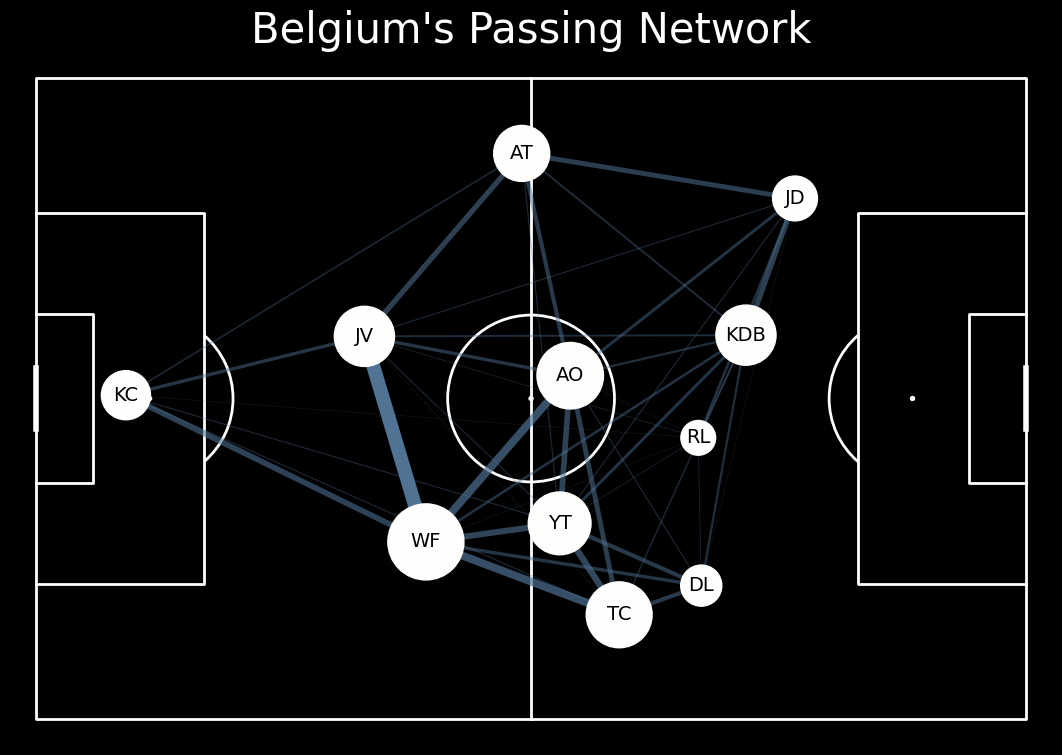

In [302]:
fig,axes = plt.subplots(1, 1, figsize=(16, 9))
fig.set_facecolor("black")
pass_network_visualization(axes, home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored,team1_facecolor)
axes.set_title(f"{teams_dict[home_team_id]}'s Passing Network", color='white', fontsize=30)

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team1}_PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor='black')

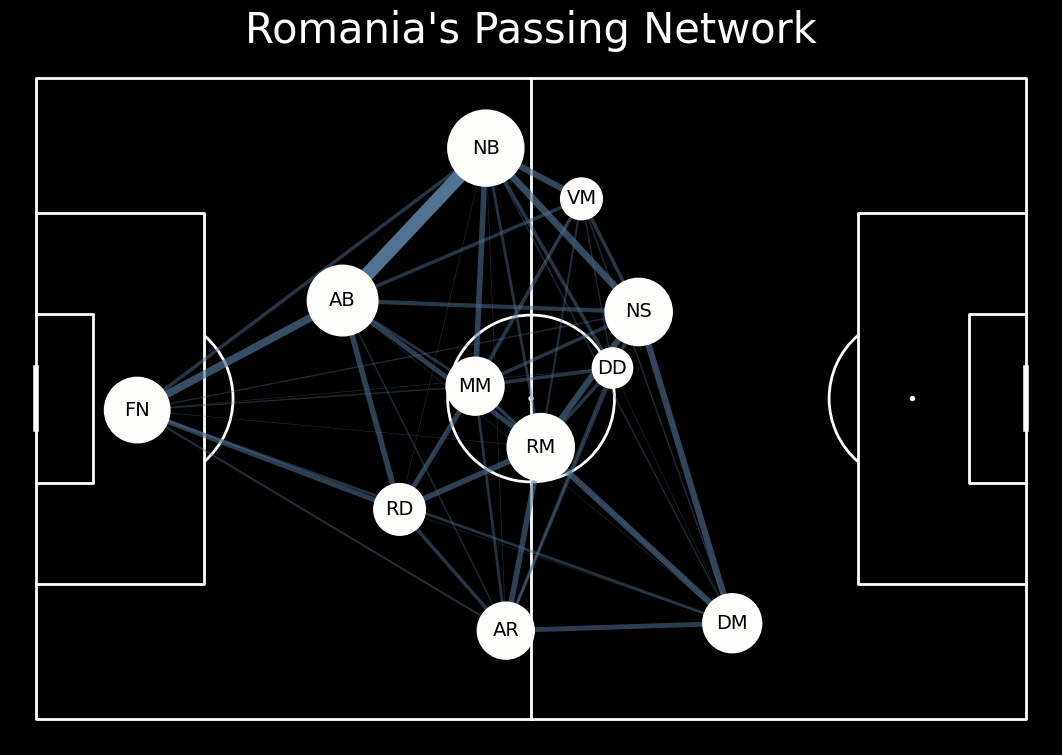

In [303]:
fig,axes = plt.subplots(1, 1, figsize=(16, 9))
fig.set_facecolor("black")
# away team viz
pass_network_visualization(axes, away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored,team2_facecolor, flipped=False)
axes.set_title(f"{teams_dict[away_team_id]}'s Passing Network", color='white', fontsize=30)

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team2}_PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor='black')

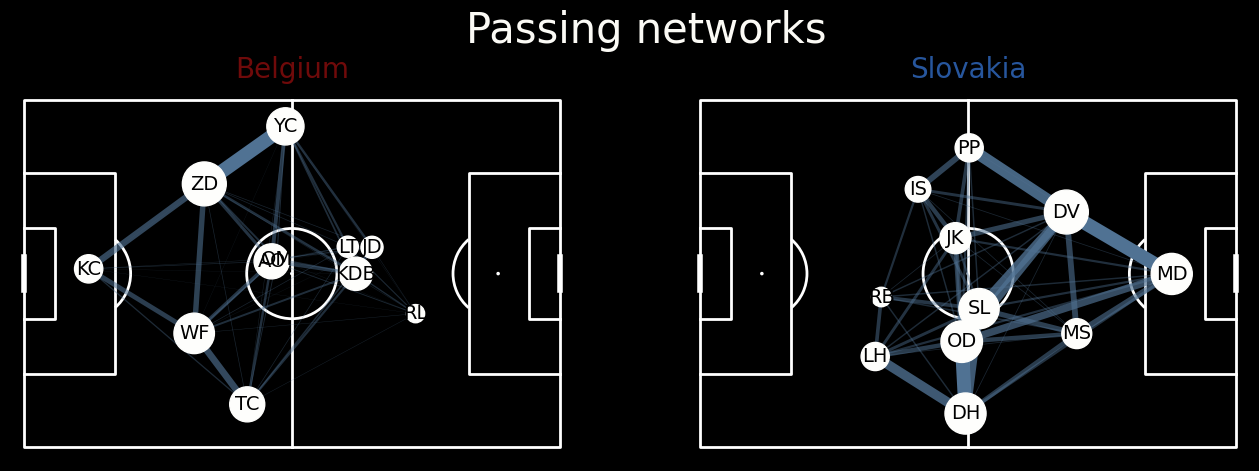

In [603]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
#plt.tight_layout()
fig.set_facecolor("black")

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(axes[0], home_passes_between_df_whoscored, home_average_locs_and_count_df_whoscored,team1_facecolor)
axes[0].set_title(teams_dict[home_team_id], color=team1_facecolor, fontsize=20)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df_whoscored, away_average_locs_and_count_df_whoscored,team2_facecolor, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=team2_facecolor, fontsize=20)

#plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=30)

#plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/PassingNetwork.png',dpi=500,bbox_inches = 'tight',facecolor='#0D182E')

## PASSMAPS

In [313]:
passes_df = passes_df_whoscored.merge(players_df_whoscored[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')

In [314]:
passes_df['name'].unique()

array(['Youri Tielemans', 'Kevin De Bruyne', 'Wout Faes',
       'Timothy Castagne', 'Koen Casteels', 'Andrei Ratiu',
       'Marius Marin', 'Nicusor Bancu', 'Dennis Man', 'Nicolae Stanciu',
       'Andrei Burca', 'Romelu Lukaku', 'Jérémy Doku', 'Denis Dragus',
       'Valentin Mihaila', 'Razvan Marin', 'Amadou Onana',
       'Jan Vertonghen', 'Arthur Theate', 'Florin Nita', 'Radu Dragusin',
       'Dodi Lukébakio', 'Leandro Trossard', 'Ianis Hagi', 'Darius Olaru',
       'Orel Mangala', 'Yannick Carrasco', 'Zeno Debast', 'Denis Alibec',
       'Deian Sorescu'], dtype=object)

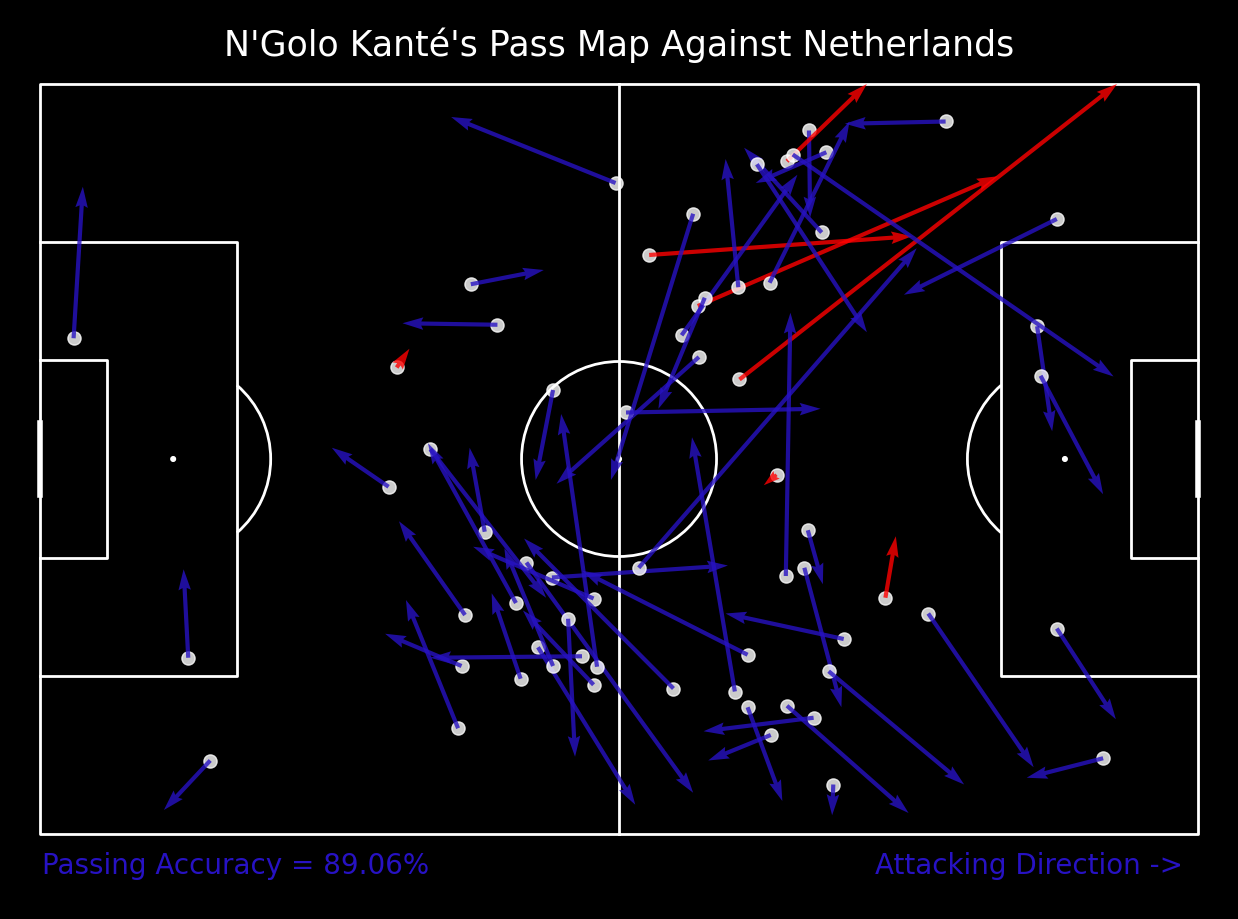

In [214]:
player = "N'Golo Kanté"
player_passes_df = passes_df.loc[(passes_df['name'] == player)]
pass_accuracy = passes_df.loc[(passes_df['name'] == player) & (passes_df['outcomeType'] == 'Successful')].shape[0] / passes_df.loc[(passes_df['name'] == player)].shape[0] 
pass_accuracy = round(pass_accuracy * 100,2)

pitch = Pitch(pitch_type='opta',pitch_color='black', line_color='white',
              pad_top=4)  # optional stripes
fig, ax = pitch.grid(grid_height=0.9, title_height=0.05, axis=False,
                     endnote_height=0.05, title_space=0, endnote_space=0)


fig.set_facecolor('black')
for index, row in player_passes_df.iterrows():
    if row['outcomeType'] == 'Successful':
        pitch.scatter(row['x'], row['y'], alpha=0.8, s=90, color='white', ax=ax['pitch'])
        pitch.arrows(row['x'], row['y'], row['endX'], row['endY'], color=team2_facecolor, ax=ax['pitch'], width=3, alpha=0.8)
    elif row['outcomeType'] == 'Unsuccessful':
        pitch.scatter(row['x'], row['y'], alpha=0.8, s=90, color='white', ax=ax['pitch'])
        pitch.arrows(row['x'], row['y'], row['endX'], row['endY'], color='red', ax=ax['pitch'], width=3, alpha=0.8)

        
fig.suptitle(f"{player}'s Pass Map Against {teams_dict[home_team_id]}", fontsize = 25,color='white')
fig.text(0.05,0.04,f"Passing Accuracy = {pass_accuracy}%",fontsize=20,color=team2_facecolor)
fig.text(0.7,0.04,"Attacking Direction ->",fontsize=20,color=team2_facecolor)
plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{player}.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PASSFLOW MAPS

In [304]:
team1_passes_df = passes_df_whoscored[passes_df_whoscored['teamId']==home_team_id]
team2_passes_df = passes_df_whoscored[passes_df_whoscored['teamId']==away_team_id]

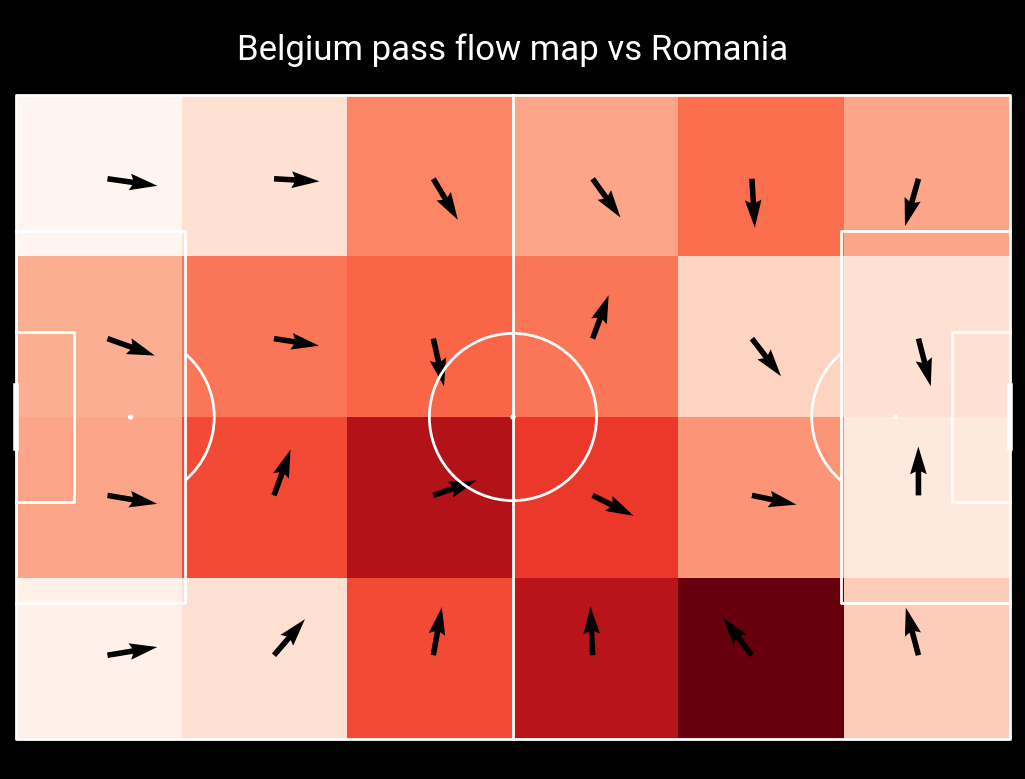

In [305]:
pitch = Pitch(pitch_type='opta', pad_bottom=1, pad_top=1,
              pad_left=1, pad_right=1,
              line_zorder=2, line_color='white', pitch_color='black')
bins = (6, 4)
fig, axs = pitch.grid(figheight=8, endnote_height=0.03, endnote_space=0,
                      title_height=0.1, title_space=0, grid_height=0.82,
                      axis=False)
fig.set_facecolor('black')

# plot the heatmap - darker colors = more passes originating from that square
bs_heatmap = pitch.bin_statistic(team1_passes_df.x, team1_passes_df.y, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=axs['pitch'], cmap='Reds')
# plot the pass flow map with a single color ('black') and length of the arrow (5)
fm = pitch.flow(team1_passes_df.x, team1_passes_df.y, team1_passes_df.endX, team1_passes_df.endY,
                color='black', arrow_type='same',
                arrow_length=5, bins=bins, ax=axs['pitch'])

# title / endnote
font = FontManager()  # default is loading robotto font from google fonts
axs['title'].text(0.5, 0.5, f'{team1} pass flow map vs {team2}',
                  fontsize=25, fontproperties=font.prop,color='white', va='center', ha='center')
#axs['endnote'].text(1, 0.5, '@indian_citizen',
                    #fontsize=18, fontproperties=font.prop,color='white', va='center', ha='right')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team1} PassFlowMap.png',dpi=500,bbox_inches = 'tight',facecolor=background)

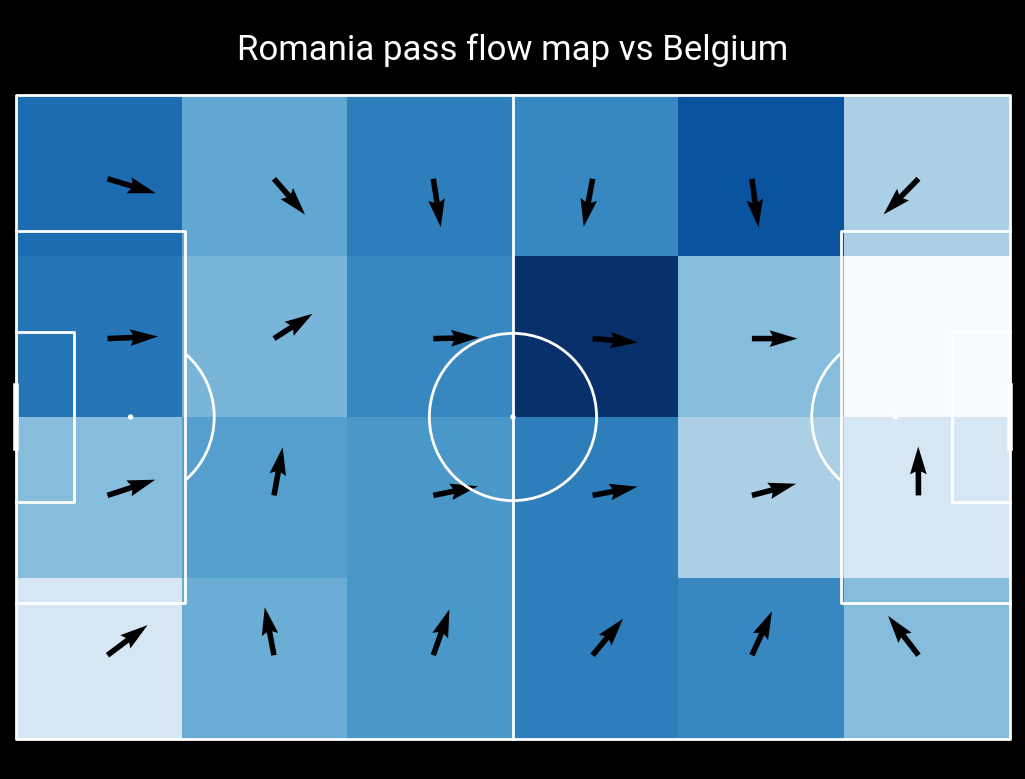

In [306]:
pitch = Pitch(pitch_type='opta', pad_bottom=1, pad_top=1,
              pad_left=1, pad_right=1,
              line_zorder=2, line_color='white', pitch_color='black')
bins = (6, 4)
fig, axs = pitch.grid(figheight=8, endnote_height=0.03, endnote_space=0,
                      title_height=0.1, title_space=0, grid_height=0.82,
                      axis=False)
fig.set_facecolor('black')

# plot the heatmap - darker colors = more passes originating from that square
bs_heatmap = pitch.bin_statistic(team2_passes_df.x, team2_passes_df.y, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=axs['pitch'], cmap='Blues')
# plot the pass flow map with a single color ('black') and length of the arrow (5)
fm = pitch.flow(team2_passes_df.x, team2_passes_df.y, team2_passes_df.endX, team2_passes_df.endY,
                color='black', arrow_type='same',
                arrow_length=5, bins=bins, ax=axs['pitch'])

# title / endnote
font = FontManager()  # default is loading robotto font from google fonts
axs['title'].text(0.5, 0.5, f'{team2} pass flow map vs {team1}',
                  fontsize=25, fontproperties=font.prop,color='white', va='center', ha='center')
#axs['endnote'].text(1, 0.5, '@indian_citizen',
                    #fontsize=18, fontproperties=font.prop,color='white', va='center', ha='right')

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{team2} PassFlowMap.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## PLAYER ANALYSIS - PassMap , ShotMap , HeatMap

In [307]:
df_players = df_whoscored.merge(players_df_whoscored,on='playerId',how='left')

In [337]:
def player_shotmap(ax,df,player):
    for index,row in df.iterrows():
        if (row['name'] == player):
            if row['eventType'] == 'Goal':
                pitch.scatter(row['y'], row['x'], color='green', s=1000, edgecolor='white', linewidth=2, alpha=0.9,marker='*',ax=ax)
            elif row['eventType'] == 'SavedShot':
                pitch.scatter(row['y'], row['x'], color='blue', s=300, edgecolor='white', linewidth=2, alpha=0.9,marker='o',ax=ax)
            elif row['eventType'] == 'MissedShots':
                pitch.scatter(row['y'], row['x'], color='red', s=300, edgecolor='white', linewidth=2, alpha=0.9,marker='x',ax=ax)

def player_passmap(ax,df,player):
    for index,row in df.iterrows():
        if (row['name'] == player):
            if row['outcomeType'] == 'Successful':
                pitch.scatter(row['y'], row['x'], alpha=0.8, s=90, color='white', ax=ax)
                pitch.arrows(row['y'], row['x'], row['endY'], row['endX'], color=team1_facecolor, ax=ax, width=3, alpha=0.8)
            if row['outcomeType'] == 'Unsuccessful':
                pitch.scatter(row['y'], row['x'], alpha=0.8, s=90, color='white', ax=ax)
                pitch.arrows(row['y'], row['x'], row['endY'], row['endX'], color='white', ax=ax, width=3, alpha=0.5)

def player_heatmap(df,player):
    for index,row in df.iterrows():
        if (row['name'] == player):
            df_temp = df[df['eventType'] == 'BallTouch']
    return df_temp

In [338]:
passes_df['name'].unique()

array(['Youri Tielemans', 'Kevin De Bruyne', 'Wout Faes',
       'Timothy Castagne', 'Koen Casteels', 'Andrei Ratiu',
       'Marius Marin', 'Nicusor Bancu', 'Dennis Man', 'Nicolae Stanciu',
       'Andrei Burca', 'Romelu Lukaku', 'Jérémy Doku', 'Denis Dragus',
       'Valentin Mihaila', 'Razvan Marin', 'Amadou Onana',
       'Jan Vertonghen', 'Arthur Theate', 'Florin Nita', 'Radu Dragusin',
       'Dodi Lukébakio', 'Leandro Trossard', 'Ianis Hagi', 'Darius Olaru',
       'Orel Mangala', 'Yannick Carrasco', 'Zeno Debast', 'Denis Alibec',
       'Deian Sorescu'], dtype=object)

In [339]:
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors",
                                                  ['#e3aca7', '#c03a1d'], N=100)
def player_report(player):
    FIGWIDTH = 16
    FIGHEIGHT = 9
    NROWS = 1
    NCOLS = 3
    SPACE = 0.09
    MAX_GRID = 0.95
    #pitch = VerticalPitch(pitch_type='opta',half=False,line_alpha=0.5, goal_alpha=0.8,corner_arcs=False,goal_type='circle',pitch_color='black')
    #fig, axs = pitch.grid(ncols=3,figheight=16,figwidth=9,title_height=0.08, title_space=0.03,endnote_space=0,axis=False)
    pitch = VerticalPitch(pitch_type='opta',pad_top=1, pad_bottom=1,
                      pad_left=1, pad_right=1,
                      pitch_color='black', stripe=False, line_color='white',line_alpha=0.5, goal_alpha=0.8,corner_arcs=False,goal_type='circle')
    GRID_WIDTH, GRID_HEIGHT = pitch.grid_dimensions(figwidth=FIGWIDTH, figheight=FIGHEIGHT,
                                                nrows=NROWS, ncols=NCOLS,
                                                max_grid=MAX_GRID, space=SPACE)
    TITLE_HEIGHT = 0.1
    ENDNOTE_HEIGHT = MAX_GRID - (GRID_HEIGHT + TITLE_HEIGHT)

    fig, axs = pitch.grid(figheight=FIGHEIGHT, grid_width=GRID_WIDTH, grid_height=GRID_HEIGHT,
                     space=SPACE, ncols=NCOLS, nrows=NROWS, title_height=TITLE_HEIGHT,
                     endnote_height=ENDNOTE_HEIGHT, axis=False)
    fig.set_facecolor("black")
    # title text
    axs['title'].text(0.5, 0.65, f"{player}'s Match Report", fontsize=30,va='center', ha='center',color='white')
    
    ## SHOTMAP
    ax_title_shotmap = axs['pitch'][0].set_title('ShotMap', fontsize = 20,color='white')
    # Set up the legend
    player_shotmap(axs['pitch'][0],df_players,player)

    legend_elements_1 = [
        Line2D([0], [0], color='green', lw=4, label='Goal'),
        Line2D([0], [0], color='blue', lw=4, label='Saved'),
        Line2D([0], [0], color='red', lw=4, label='Miss')
    ]
    axs['pitch'][0].legend(handles=legend_elements_1, facecolor='#22312b', handlelength=3, edgecolor='white', fontsize=15, loc='lower left',labelcolor='w',bbox_to_anchor=(0.1, 0.1))
    #axs['pitch'][0].legend(facecolor='#22312b', handlelength=3, edgecolor='white', fontsize=16, loc='upper left',labelcolor='w',bbox_to_anchor=(0.06, 0.95))

    ## PASSMAP
    ax_title_passmap = axs['pitch'][1].set_title('PassMap', fontsize = 20,color='white')
    # Set up the legend
    player_passmap(axs['pitch'][1],passes_df,player)

    legend_elements_2 = [
        Line2D([0], [0], color=team1_facecolor, lw=4, label='Successful'),
        Line2D([0], [0], color='white', lw=4, label='Unsuccessful')
    ]
    axs['pitch'][1].legend(handles=legend_elements_2, facecolor='#22312b', handlelength=3, edgecolor='white', fontsize=15, loc='lower left',labelcolor='w',bbox_to_anchor=(0.1, 0.1))

    ## HEATMAP
    ax_title_heatmap = axs['pitch'][2].set_title('TouchMap', fontsize = 20,color='white')
    #player_heatmap(axs['pitch'][2],df_players,player)
    df_temp = player_heatmap(df_players,player)
    pitch.kdeplot(df_temp.x, df_temp.y, ax=axs['pitch'][2], cmap=flamingo_cmap,fill=True,levels=10,alpha=0.6)

    plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/{player}_Report.png',dpi=500,bbox_inches = 'tight',facecolor=background)
    

UnboundLocalError: local variable 'df_temp' referenced before assignment

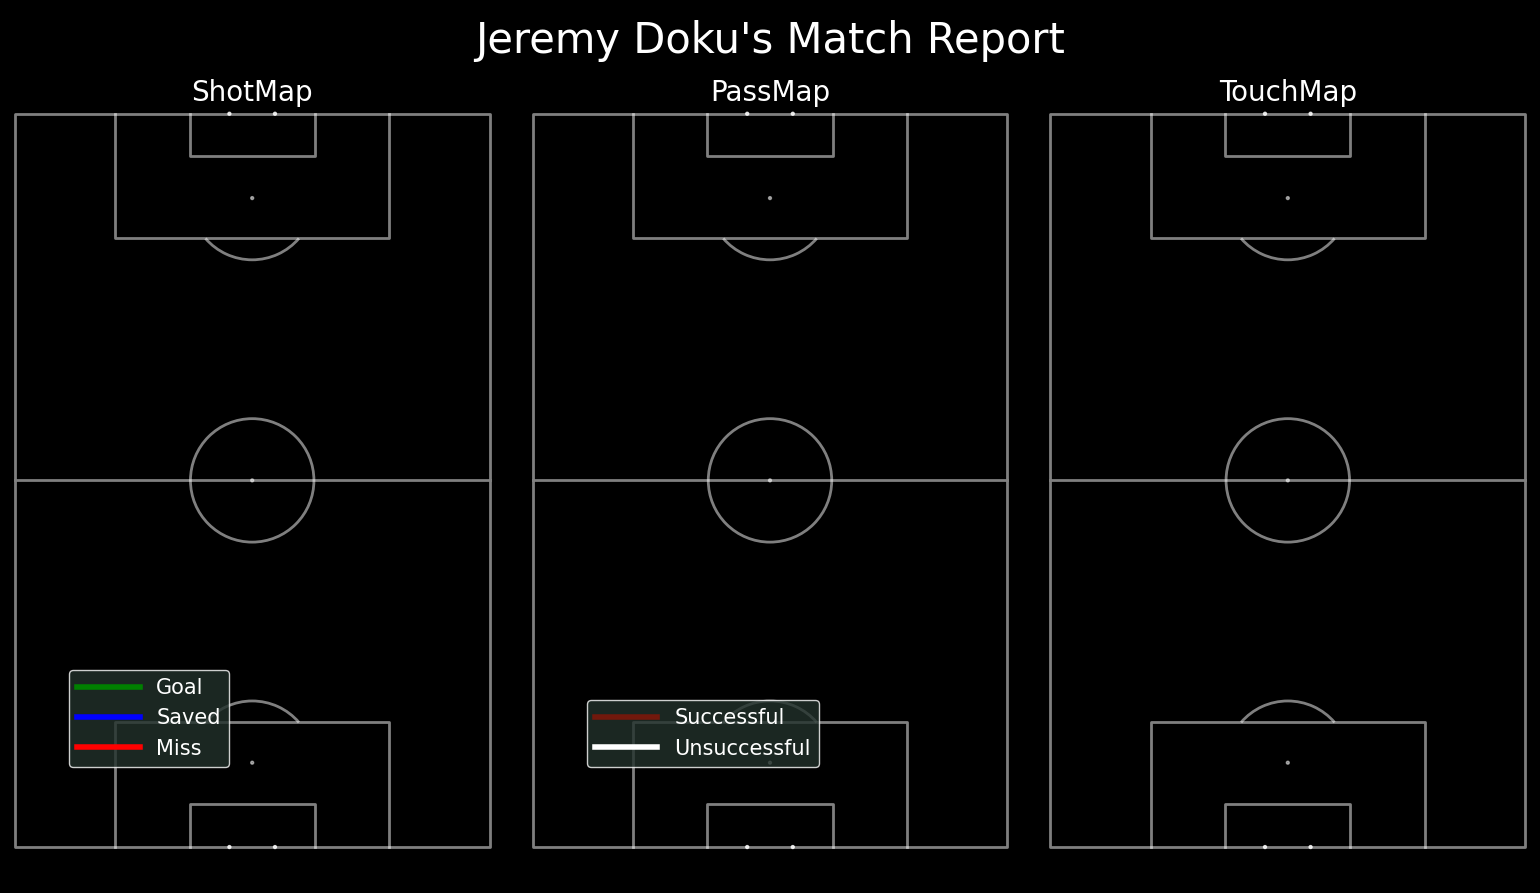

In [340]:
player_report('Jeremy Doku')

## xG FLOW CHART

In [226]:
df_shots.columns

Index(['id', 'eventType', 'teamId', 'playerId', 'playerName', 'x', 'y', 'min',
       'minAdded', 'isBlocked', 'isOnTarget', 'blockedX', 'blockedY',
       'goalCrossedY', 'goalCrossedZ', 'expectedGoals',
       'expectedGoalsOnTarget', 'shotType', 'situation', 'period', 'isOwnGoal',
       'onGoalShot', 'isSavedOffLine', 'isFromInsideBox', 'firstName',
       'lastName', 'fullName', 'teamColor', 'matchId'],
      dtype='object')

In [321]:
team1Id, team2Id = df_shots.teamId.unique()

In [322]:
df_xG = df_shots[['teamId','playerName','min','expectedGoals','expectedGoalsOnTarget','eventType','minAdded']]
df_xG['teamName'] = df_xG.apply(lambda x: hometeam if x['teamId'] == team1Id else (awayteam if x['teamId'] == team2Id else None), axis=1)

df_xG['cumulative_xG'] = df_xG.groupby('teamName')['expectedGoals'].cumsum()
df_xG['cumulative_xGOT'] = df_xG.groupby('teamName')['expectedGoalsOnTarget'].cumsum()

df_xG['half'] = df_xG['min'].apply(lambda x: 1 if x <= 45 else 2)

df_xG['min'] = df_xG['min'] + df_xG['minAdded'].fillna(0)

C:\Users\acer\AppData\Local\Temp\ipykernel_127352\27347590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xG['teamName'] = df_xG.apply(lambda x: hometeam if x['teamId'] == team1Id else (awayteam if x['teamId'] == team2Id else None), axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_127352\27347590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xG['cumulative_xG'] = df_xG.groupby('teamName')['expectedGoals'].cumsum()
C:\Users\acer\AppData\Local\Temp\ipykernel_127352\27347590.py:5: SettingWit

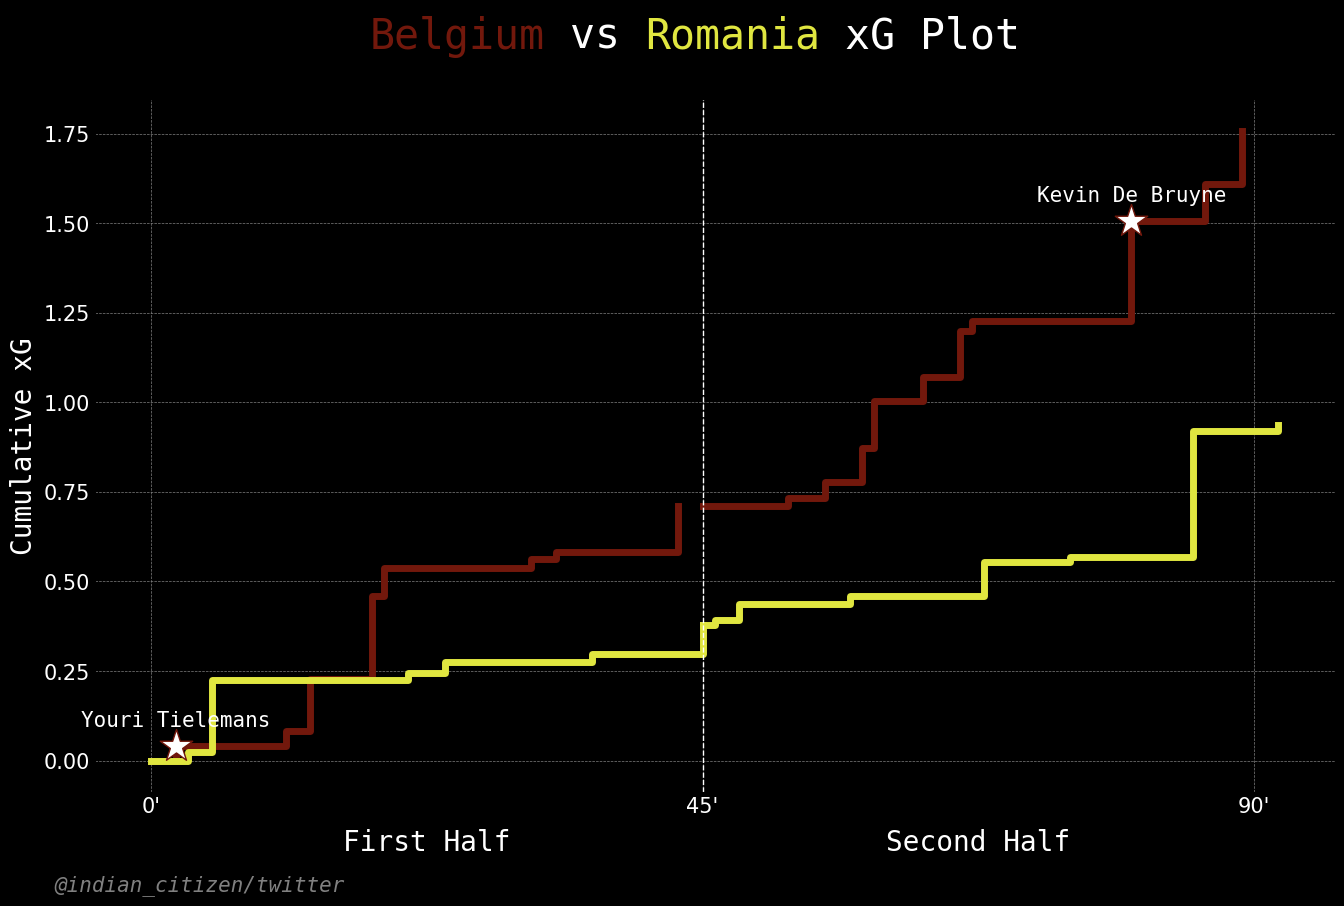

In [333]:
fig, ax = plt.subplots(figsize=(16, 9))
fig.set_facecolor('black')
ax.set_facecolor('black')
# Plot the xG for each team by half
# We want to make it so the lines both start at 0

for team in df_xG['teamName'].unique():
    
    team_df = df_xG[df_xG['teamName'] == team]
    
    # add a 0 xG row at the start of the match
    team_df = pd.concat([pd.DataFrame({'teamName': team, 'min': 0, 'expectedGoals': 0, 'eventType': 'Goal', 'cumulative_xG': 0, 'half': 1}, index=[0]), team_df])
    
    # Also add a row at the beginning of the second half to make the lines start where the first half ended
    team_df = pd.concat([team_df[team_df['half'] == 1], pd.DataFrame({'teamName': team, 'min': 45, 'expectedGoals': 0, 'eventType': 'Goal', 'cumulative_xG': team_df[team_df['half'] == 1]['cumulative_xG'].iloc[-1], 'half': 2}, index=[0]), team_df[team_df['half'] == 2]])

    for half in team_df['half'].unique():
        half_df = team_df[team_df['half'] == half]
        ax.plot(
            half_df['min'], 
            half_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=team1_facecolor if team == hometeam else team2_facecolor,
            linewidth=5
        )   
        

# We Can add a scatter plot to show the goals
for team in df_xG['teamName'].unique():
    team_df = df_xG[(df_xG['teamName'] == team) & (df_xG['eventType'] == 'Goal')].to_dict(orient='records')
    for x in team_df:
        ax.scatter(
            x['min'], 
            x['cumulative_xG'], 
            c='white',
            edgecolor=team1_facecolor if team == hometeam else team2_facecolor,
            s=600,
            marker='*',
            # We want the goals to be on top of the lines
            zorder=5
        )
        
        # add a label to the goals for the player who scored
        ax.text(
            x['min'], 
            x['cumulative_xG'] + .07, 
            x['playerName'], 
            ha='center', 
            va='center',
            c='white',
            fontfamily='monospace', 
            fontsize=15,
            zorder=10
        )
        
# Let's label the x axis with first and second half
ax.set_xticks([0, 45, 90])
ax.set_xticklabels(['0\'', '45\'', '90\''])

# Lets add the actual words "First Half" and "Second Half" to the plot under the x axis
ax.text(22.5, -.25, 'First Half', ha='center', fontfamily='monospace', fontsize=20,color='white')
ax.text(67.5, -.25, 'Second Half', ha='center', fontfamily='monospace', fontsize=20,color='white')

# Let's label the y axis with the cumulative xG
ax.set_ylabel('Cumulative xG', fontfamily='monospace', fontsize=20,color='white')

# Let's get rid of the right and top spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='both', length=0)

ax.tick_params(axis='x', colors='white', labelsize=15)
ax.tick_params(axis='y', colors='white', labelsize=15)

ax.axvline(x=45, color='white', linestyle='--', linewidth=1)


# Let's change the color of the title to show which team is which using the highlight-text package
from highlight_text import fig_text

fig_text(
    0.5,
    0.95,
    '<Belgium> vs <Romania> xG Plot', 
    fontsize=30, 
    ha='center', 
    va='center', 
    ax=ax,
    color='white',
    fontfamily='monospace', 
    highlight_textprops=[{'color': team1_facecolor}, {'color': team2_facecolor}]
)


# Now let's add a twitter @ to the bottom left of the plot
fig.text(
    0.1, 
    0.00, 
    '@indian_citizen/twitter', 
    fontsize=15, 
    fontstyle='oblique', 
    fontfamily='monospace', 
    color='grey'
)

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/MatchReports/EUROS-24/{team1}V{team2}/xGPlot.png',dpi=500,bbox_inches = 'tight',facecolor=background)